# Data Acquisition

In [1]:
# Basic packages
import numpy as np 
import pandas as pd 
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting



# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

In [2]:
COE = pd.read_csv('M11-coe_results_updated.csv')
REVAL = pd.read_csv('M10-Monthly_COE_Revalidation.csv')

# Extracting relevant Data (Cat A)

Looking at ONLY Cat A:

In [3]:
COEA=COE[COE["vehicle_class"]=="Category A"]
COEA=COEA.reset_index(drop=True)

REVALA=REVAL[REVAL["category"]=="Category A"]
REVALA=REVAL.reset_index(drop=True)

Set bidding made on 1st Monday of week to be 1, 3rd Monday of week: 15

In [4]:
i=0
length_df=len(COEA)
while(i<length_df):
    if(i%2==0):
        COEA["month"][i]=COEA["month"][i]+"-01"
    else:
         COEA["month"][i]=COEA["month"][i]+"-15"
    i+=1
COEA["month"]=pd.to_datetime(COEA["month"])

In [5]:
i=0
length_df=len(REVALA)
while(i<length_df):
    if(i%2==0):
        REVALA["month"][i]=REVALA["month"][i]+"-01"
    else:
         REVALA["month"][i]=REVALA["month"][i]+"-15"
    i+=1
REVALA["month"]=pd.to_datetime(REVALA["month"])

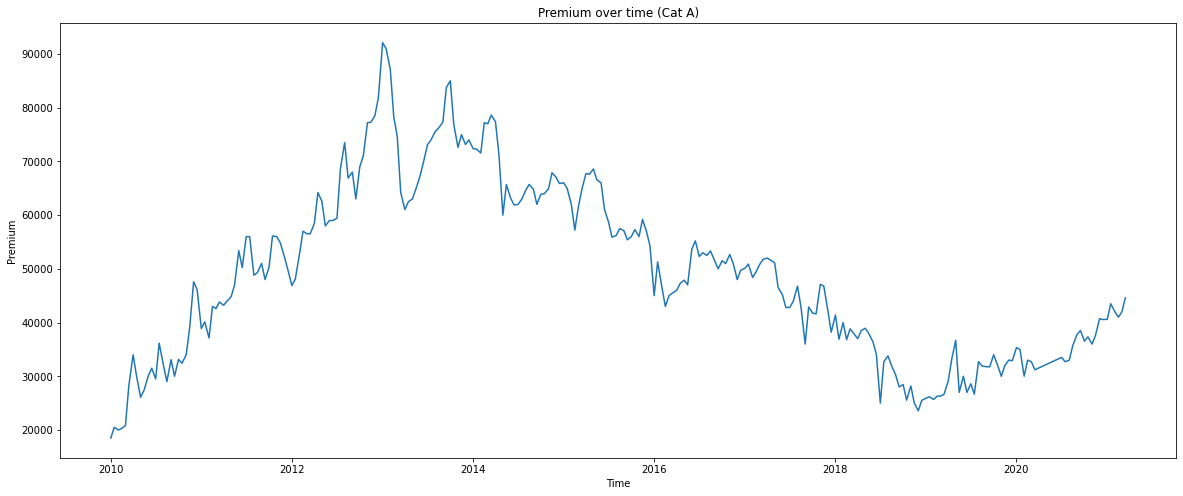

In [6]:
tp=COEA.groupby(["month"])["premium"].sum()
fig = plt.figure(figsize=(20,8))

plt.title('Premium over time (Cat A)')
plt.xlabel('Time')
plt.ylabel('Premium')

plt.plot(tp)

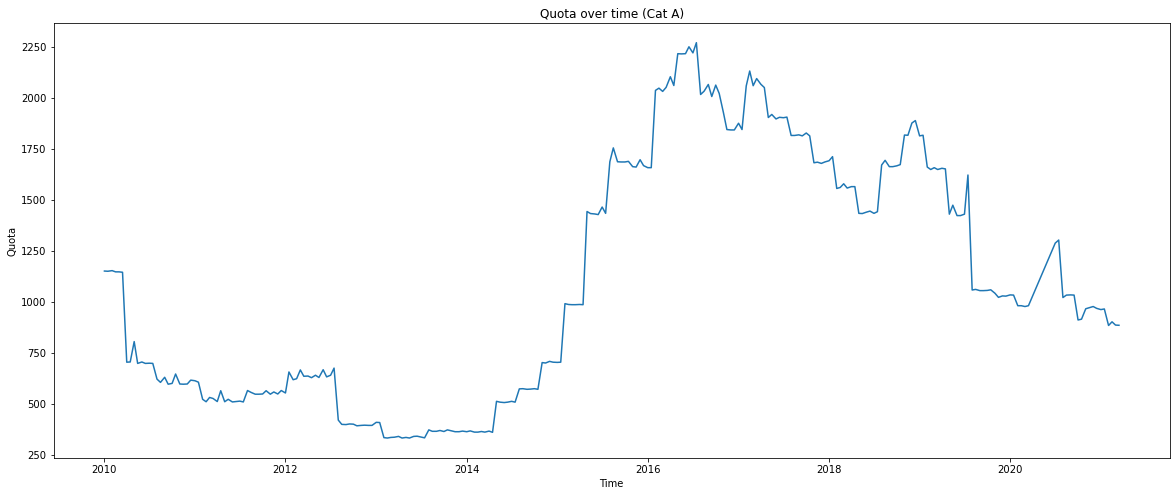

In [7]:
tp=COEA.groupby(["month"])["quota"].sum()
plt.figure(figsize=(20,8))
plt.title('Quota over time (Cat A)')
plt.xlabel('Time')
plt.ylabel('Quota')
plt.plot(tp)

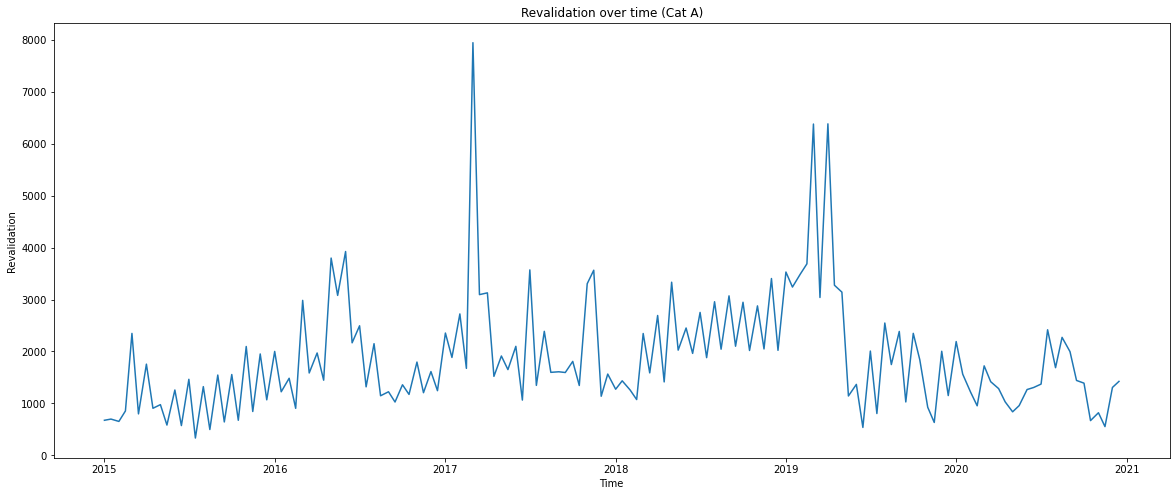

<Figure size 432x288 with 0 Axes>

In [8]:
tp=REVALA.groupby(["month"])["number"].sum()
plt.figure(figsize=(20,8))
plt.title('Revalidation over time (Cat A)')
plt.xlabel('Time')
plt.ylabel('Revalidation')
plt.plot(tp)
fig = plt.figure()
fig.patch.set_facecolor('white')

# Selecting relevant time window 

In [9]:
COEA2019 = pd.DataFrame(COEA.iloc[214:])
COEA2019.head()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
214,2018-12-01,1,Category A,1878,1878,2177,23568
215,2018-12-15,2,Category A,1890,1887,2729,25501
216,2019-01-01,1,Category A,1815,1804,2707,25920
217,2019-01-15,2,Category A,1818,1818,2864,26170
218,2019-02-01,1,Category A,1662,1653,2371,25689


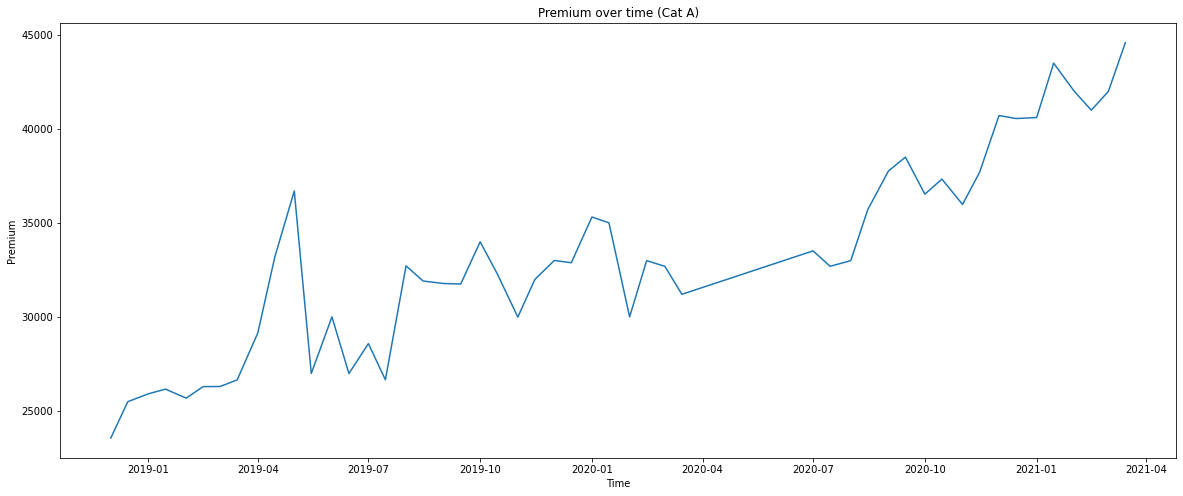

In [10]:
tp=COEA2019.groupby(["month"])["premium"].sum()
fig = plt.figure(figsize=(20,8))
plt.title('Premium over time (Cat A)')
plt.xlabel('Time')
plt.ylabel('Premium')
plt.plot(tp)

# Checking stationarity of Series Using Augmented Dickey-Fuller Test

In [11]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window =6).mean()
    rolstd = timeseries.rolling(window =6).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

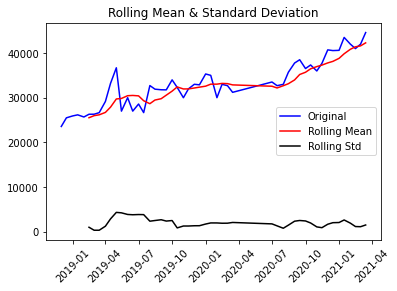

Results of Dickey-Fuller Test:
Test Statistic                  0.270401
p-value                         0.975945
#Lags Used                      6.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


In [12]:
premium_a = COEA2019.groupby(["month"])["premium"].sum()
test_stationarity(premium_a)

Since test statistic is not less than critical value,  we do not reject null hypothesis. Series is non-stationary.

# Stationarising series

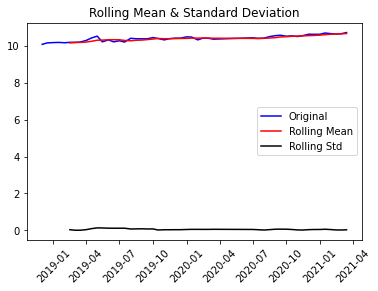

Results of Dickey-Fuller Test:
Test Statistic                 -0.389111
p-value                         0.911901
#Lags Used                      6.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


In [13]:
a2019_log = np.log(premium_a)
test_stationarity(a2019_log)

(array([17897., 17987., 18078., 18170., 18262., 18353., 18444., 18536.,
        18628., 18718.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

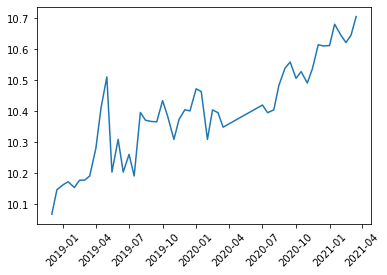

In [14]:
plt.plot(a2019_log)
plt.xticks(rotation=45)

Series is still non-stationary

In [15]:
a2019_log_moving_avg = a2019_log.rolling(6).mean()
a2019_log_moving_avg.dropna(inplace=True)


In [16]:
a2019_log_moving_avg_diff = a2019_log - a2019_log_moving_avg
a2019_log_moving_avg_diff.head(6)

month
2018-12-01         NaN
2018-12-15         NaN
2019-01-01         NaN
2019-01-15         NaN
2019-02-01         NaN
2019-02-15    0.030623
Name: premium, dtype: float64

Need to drop first 5 NaN values

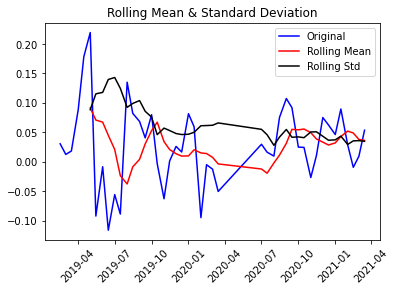

Results of Dickey-Fuller Test:
Test Statistic                 -5.347982
p-value                         0.000004
#Lags Used                      5.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


In [17]:
a2019_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(a2019_log_moving_avg_diff)

Test Statistic is lower than all critical values. We can say with 99% confidence that series is now stationary after performing one order of differencing.

#  AR and MA modeling

In [18]:
lag_acf = acf(a2019_log_moving_avg_diff, nlags=12)
lag_pacf = pacf(a2019_log_moving_avg_diff, nlags=12, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

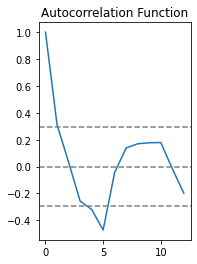

In [19]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(a2019_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(a2019_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

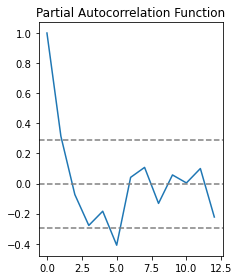

In [20]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(a2019_log_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(a2019_log_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Both Autocorrelation and Partial Autocorrealtion Functions cross 0 at lag order of 2. We will be basing the best parameters (AR and MA components) around that value.

# Finding best ARIMA parameters using Cross Validation

Using Cross Validation

In [21]:
import pmdarima as pm
from pmdarima import model_selection

A grid search for the best parameters for AR and MA component is done for values between 1 and 6. Differencing order is fixed at 1. We used the Sliding Window Forecast Cross Validation to judge the goodness of each model. the criteria used was the total mean squared error. We also experimented with various window sizes for the cross validation to find the best model.

In [22]:
lowestError = 100
ARval = 0
MAval = 0
for i in range (6):
    for j in range(6):
        try:
            model = pm.ARIMA(order=(i, 1, j))
            cv = model_selection.SlidingWindowForecastCV(window_size=12, step=2, h=2)
            cv_score = model_selection.cross_val_score( model, a2019_log, scoring='mean_squared_error', cv=cv, verbose=2)
            error_sum = sum(cv_score)
            if error_sum < lowestError:
                lowestError = error_sum
                ARval = i+1
                MAval = j+1
        except:
            True
print("the best model has AR value of ",ARval, " and MA value of ",MAval)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

Using (window_size=12, step=2, h=2)

(array([17897., 17987., 18078., 18170., 18262., 18353., 18444., 18536.,
        18628., 18718.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

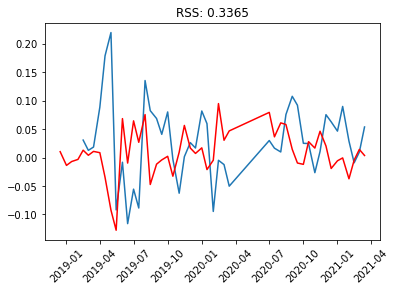

In [23]:
model = ARIMA(a2019_log, order=(2, 1, 1))  
results_AR = model.fit(disp=-1)  
plt.plot(a2019_log_moving_avg_diff)
plt.plot(results_AR.fittedvalues, color='red')
RSS = (results_AR.fittedvalues-a2019_log_moving_avg_diff)**2
RSS.dropna(inplace =True)
plt.title('RSS: %.4f'% sum(RSS))
plt.xticks(rotation=45)

(array([17897., 17987., 18078., 18170., 18262., 18353., 18444., 18536.,
        18628., 18718.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

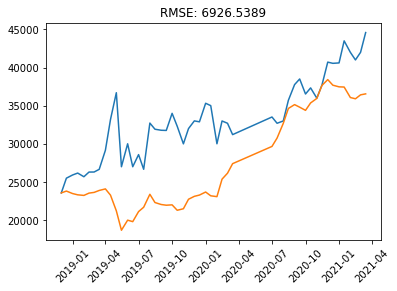

In [24]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(a2019_log[0], index=a2019_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(premium_a)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-premium_a)**2)/len(premium_a)))
plt.xticks(rotation=45)

The model for the actual premium values does not look too good, with the predicted values almost always below the actual values. We doubled the window size and performed the grid search and cross validation once more.

Using (window_size=24, step=2, h=2)

In [25]:
lowestError = 100
ARval = 0
MAval = 0
for i in range (6):
    for j in range(6):
        try:
            model = pm.ARIMA(order=(i, 1, j))
            cv = model_selection.SlidingWindowForecastCV(window_size=24, step=2, h=2)
            cv_score = model_selection.cross_val_score( model, a2019_log, scoring='mean_squared_error', cv=cv, verbose=2)
            error_sum = sum(cv_score)
            if error_sum < lowestError:
                lowestError = error_sum
                ARval = i+1
                MAval = j+1
        except:
            True
print("the best model has AR value of ",ARval, " and MA value of ",MAval)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=0 ..........................................................
[CV] f

(array([17897., 17987., 18078., 18170., 18262., 18353., 18444., 18536.,
        18628., 18718.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

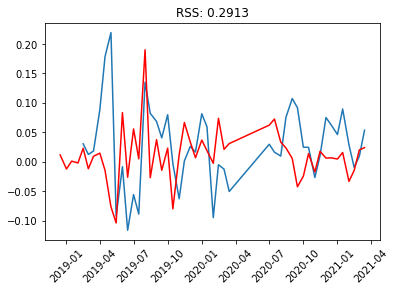

In [26]:
model = ARIMA(a2019_log, order=(5, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(a2019_log_moving_avg_diff)
plt.plot(results_AR.fittedvalues, color='red')
RSS = (results_AR.fittedvalues-a2019_log_moving_avg_diff)**2
RSS.dropna(inplace =True)
plt.title('RSS: %.4f'% sum(RSS))
plt.xticks(rotation=45)

(array([17897., 17987., 18078., 18170., 18262., 18353., 18444., 18536.,
        18628., 18718.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

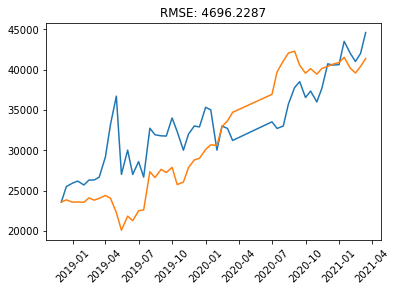

In [27]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(a2019_log[0], index=a2019_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(premium_a)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-premium_a)**2)/len(premium_a)))
plt.xticks(rotation=45)

The model here looks better fitted with a lower RMSE. We will use the ARIMA model with order of (5,1,2) to predict the premium values for April (and/or beyond)

# A different approach

Instead of using cross validation to check the goodness of fit using various parameters, we also tried another process where we skip the cross validation use the RMSE between actual and predicted original (non-logged) data. This method is more computaionally demanding and less proper. We commented out all the code because we will not be using the results of this method. Nevertheless, we got an ARIMA model with order of (6,1,1) using this method and the plot for the predicted original (non-logged) values looks similar to the ARIMA model with order of (5,1,2), with a RMSE value of around 4.4k.

In [28]:
"""
lowestRMSE = 10000
ARval = 0
MAval = 0
for i in range(6):
    for j in range(6):
        try :
            model = ARIMA(a2019_log, order=(i+1, 1, j+1))  
            results_AR = model.fit(disp=-1)
            predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
            predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
            predictions_ARIMA_log = pd.Series(a2019_log[0], index=a2019_log.index)
            predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
            predictions_ARIMA = np.exp(predictions_ARIMA_log)
            RMSE = np.sqrt(sum((predictions_ARIMA-premium_a)**2)/len(premium_a))
            if RMSE < lowestRMSE:
                lowestRMSE = RMSE
                ARval = i+1
                MAval = j+1
        except:
            True
print("the best model has AR value of ",ARval, " and MA value of ",MAval)
"""

'\nlowestRMSE = 10000\nARval = 0\nMAval = 0\nfor i in range(6):\n    for j in range(6):\n        try :\n            model = ARIMA(a2019_log, order=(i+1, 1, j+1))  \n            results_AR = model.fit(disp=-1)\n            predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)\n            predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()\n            predictions_ARIMA_log = pd.Series(a2019_log[0], index=a2019_log.index)\n            predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)\n            predictions_ARIMA = np.exp(predictions_ARIMA_log)\n            RMSE = np.sqrt(sum((predictions_ARIMA-premium_a)**2)/len(premium_a))\n            if RMSE < lowestRMSE:\n                lowestRMSE = RMSE\n                ARval = i+1\n                MAval = j+1\n        except:\n            True\nprint("the best model has AR value of ",ARval, " and MA value of ",MAval)\n'

In [29]:
"""
model = ARIMA(a2019_log, order=(6, 1, 1))  
results_AR = model.fit(disp=-1)  
plt.plot(a2019_log_moving_avg_diff)
plt.plot(results_AR.fittedvalues, color='red')
RSS = (results_AR.fittedvalues-a2019_log_moving_avg_diff)**2
RSS.dropna(inplace =True)
plt.title('RSS: %.4f'% sum(RSS))
plt.xticks(rotation=45)
"""

"\nmodel = ARIMA(a2019_log, order=(6, 1, 1))  \nresults_AR = model.fit(disp=-1)  \nplt.plot(a2019_log_moving_avg_diff)\nplt.plot(results_AR.fittedvalues, color='red')\nRSS = (results_AR.fittedvalues-a2019_log_moving_avg_diff)**2\nRSS.dropna(inplace =True)\nplt.title('RSS: %.4f'% sum(RSS))\nplt.xticks(rotation=45)\n"

In [30]:
"""
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(a2019_log[0], index=a2019_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(premium_a)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-premium_a)**2)/len(premium_a)))
plt.xticks(rotation=45)
"""

"\npredictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)\npredictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()\npredictions_ARIMA_log = pd.Series(a2019_log[0], index=a2019_log.index)\npredictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)\npredictions_ARIMA = np.exp(predictions_ARIMA_log)\nplt.plot(premium_a)\nplt.plot(predictions_ARIMA)\nplt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-premium_a)**2)/len(premium_a)))\nplt.xticks(rotation=45)\n"

# The verdicts

In [31]:
premium_a.count()

50

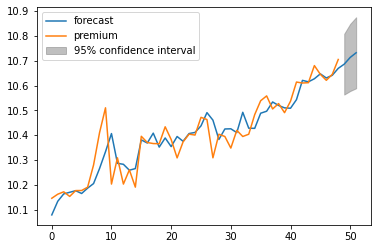

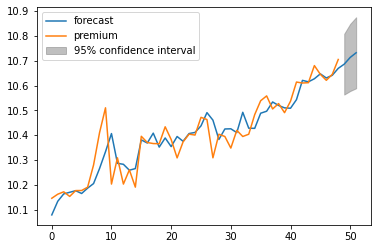

In [32]:
results_AR.plot_predict(1,52)

In [33]:
results_AR.forecast(steps = 2)
x = results_AR.forecast(steps = 2)
x[0]

array([10.68636605, 10.71015688])

In [34]:
predictions = np.exp(x[0])
print("The predicted premiums for the month of April:",np.floor(predictions[0]), "and", np.floor(predictions[1])) 

The predicted premiums for the month of April: 43755.0 and 44808.0
